# CICERO SCM notebook - parallel using openscm-runner


Import some stuff

In [4]:
import sys
import re
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import pandas.testing as pdt
import warnings
import logging

try:
    from pandas.core.common import SettingWithCopyWarning
except:
    from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.filterwarnings("ignore", message=".*Parameter.*")

In [57]:
import concurrent

In [5]:
actual_cpu_count = os.cpu_count()
print(actual_cpu_count)

256


In [6]:
logger = logging.getLogger(__name__)
logging.basicConfig(filename='example.log', encoding='utf-8', level=logging.DEBUG)

In [7]:
from openscm_runner.adapters.utils.cicero_utils.cicero_forcing_postprocessing_common import openscm_to_cscm_dict


/uio/kant/div-cicero-u1/bensan/ciceroscm-1/venv/lib/python3.8/site-packages/scmdata/database/_database.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdman
/uio/kant/div-cicero-u1/bensan/ciceroscm-1/venv/lib/python3.8/site-packages/setuptools_scm/_integration/setuptools.py:31: RuntimeWarning: 
ERROR: setuptools==47.1.0 is used in combination with setuptools_scm>=8.x

Your build configuration is incomplete and previously worked by accident!
setuptools_scm requires setuptools>=61

Suggested workaround if applicable:
 - migrating from the deprecated setup_requires mechanism to pep517/518
   and using a pyproject.toml to declare build dependencies
   which are reliably pre-installed before running the build tools

  warnings.warn(


<IPython.core.display.Javascript object>

In [8]:
from ciceroscm.parallel._configdistro import _ConfigDistro
from ciceroscm.parallel.calibrator import Calibrator
from ciceroscm.parallel.distributionrun import DistributionRun


Import the model

In [9]:
sys.path.insert(0,os.path.join(os.getcwd(), '../', 'src'))
from ciceroscm import CICEROSCM

Define some input handling functions to give us example inputs

In [10]:
from ciceroscm.input_handler import read_inputfile,read_components,read_natural_emissions

Define a function to convert model output to a dataframe

In [11]:
def to_df(cscm):
    out=pd.concat([pd.DataFrame(v) for k, v in cscm.results.items()], axis = 1, keys = list(cscm.results.keys()))
    return out

set up input directories

In [12]:
test_data_dir = os.path.join(os.getcwd(), '../', 'tests', 'test-data')

# Read in datafiles into dataframes

In [13]:
# NBVAL_IGNORE_OUTPUT
#Read gas parameters
gaspam =read_components(test_data_dir + '/gases_v1RCMIP.txt')
gaspam.head()

,EM_UNIT,CONC_UNIT,BETA,ALPHA,TAU1,TAU2,TAU3,NAT_EM,SARF_TO_ERF
GAS,,,,,,,,,
CO2,Pg_C,ppm,2.123,0.00000,150.00,0,0,0.0,1.000000
CH4,Tg,ppb,2.780,0.00000,9.60,120,160,275.0,0.877193
N2O,Tg_N,ppb,4.810,0.00000,121.00,0,0,9.5,1.000000
SO2,Tg_S,-,11.000,0.00000,0.02,0,0,0.0,1.000000
CFC-11,Gg,ppt,22.600,0.00026,45.00,0,0,0.0,1.000000


Read natural emissions

In [14]:
# NBVAL_IGNORE_OUTPUT
df_nat_ch4 =read_natural_emissions(test_data_dir + '/natemis_ch4.txt','CH4')
df_nat_n2o =read_natural_emissions(test_data_dir + '/natemis_n2o.txt','N2O')
df_nat_ch4.head()


,CH4
year,
1750,269.4273
1751,270.9068
1752,273.0183
1753,272.0470
1754,271.1915


Read forcing

In [15]:
df_ssp2_conc =read_inputfile(test_data_dir + '/ssp245_conc_RCMIP.txt')
df_ssp2_conc.head()

,CO2,CH4,N2O,CFC-11,CFC-12,CFC-113,CFC-114,CFC-115,CH3Br,CCl4,...,HFC143a,HFC227ea,HFC23,HFC245fa,HFC32,HFC4310mee,C2F6,C6F14,CF4,SF6
Component,,,,,,,,,,,,,,,,,,,,,
1700,276.746000,706.054021,272.212049,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1701,276.749995,706.247004,272.243047,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1702,276.757998,706.375031,272.266047,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1703,276.757001,706.491002,272.298047,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1704,276.755000,706.602046,272.331052,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0


In [16]:
emi_input =read_inputfile(test_data_dir + '/ssp245_em_RCMIP.txt')
emi_input.rename(columns={"CO2": "CO2_FF", "CO2.1": "CO2_AFOLU"}, inplace=True)
emi_input.head()

,CO2_FF,CO2_AFOLU,CH4,N2O,SO2,CFC-11,CFC-12,CFC-113,CFC-114,CFC-115,...,CF4,SF6,NOx,CO,NMVOC,NH3,BMB_AEROS_BC,BMB_AEROS_OC,BC,OC
Component,,,,,,,,,,,,,,,,,,,,,
1750,0.002592,0.081127,19.019783,0.054710,1.222464,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.871504,348.527359,60.021826,6.927690,1.353250,12.520269,0.744520,2.927399
1751,0.002593,0.082619,18.915109,0.055744,1.206598,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.828060,343.926367,59.088126,6.860142,1.335274,12.279280,0.737652,2.909437
1752,0.002594,0.084139,18.889712,0.056797,1.200955,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.828658,341.809034,58.631997,6.819482,1.326617,12.121816,0.737695,2.912659
1753,0.002594,0.085687,19.121377,0.057870,1.207757,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.812105,343.675456,59.026349,6.881439,1.328560,12.249330,0.743391,2.933215
1754,0.002595,0.087263,19.509061,0.058963,1.233495,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.841598,349.815625,60.269945,7.015189,1.346553,12.593635,0.752796,2.965138


# Set up model run with defined input variables

In [17]:
scendata={
            "gaspam_data": gaspam,
            "emstart": 1750,  
            "conc_run":True,
            "nystart": 1750,
            "nyend": 2100,
            "concentrations_data": df_ssp2_conc,
            "emissions_data": emi_input,
            "nat_ch4_data": df_nat_ch4,
            "nat_n2o_data": df_nat_n2o,
            "idtm":24,
            "udir": test_data_dir,
            "scenname": "ssp245",
        }

In [18]:
    calibdata = pd.DataFrame(
        data={
            "Variable Name": [
                "Heat Content|Ocean",
                "Surface Air Ocean Blended Temperature Change",
            ],
            "Yearstart_norm": [1971, 1961],
            "Yearend_norm": [1971, 1990],
            "Yearstart_change": [2018, 2000],
            "Yearend_change": [2018, 2019],
            "Central Value": [320.69251537323, 0.5372],
            "sigma": [17.020342912051203, 0.039028311931729676],
        })

In [19]:
    testconfig = _ConfigDistro(
        distro_array=[],
        ordering=["aerosol_total", "W", "lambda", "beta_f"],
        setvalues={
            "threstemp": 7.0,
            "lm": 40,
            "ldtime": 12,
            "qbmb": 0,
            "qo3": 0.5,
            "qh2o_ch4": 0.091915,
            "rlamdo": 16,
            "akapa": 0.634,
            "cpi": 0.4,
            "beto": 3.5,
            "mixed": 60,
            "foan":0.61,
        },
        options={"aerosol_total": [-0.36, -0.97, 0.16, -0.08]}
    )

In [67]:
# NBVAL_IGNORE_OUTPUT
scen = 'test'
cscm_dir=CICEROSCM({
            "gaspam_data": gaspam,
            "emstart": 1750,  
            "conc_run":True,
            "nystart": 1750,
            "nyend": 2100,
            "concentrations_data": df_ssp2_conc,
            "emissions_data": emi_input,
            "nat_ch4_data": df_nat_ch4,
            "nat_n2o_data": df_nat_n2o,
            "idtm":24,
        })

In [20]:
testconfig.ordering

['aerosol_total', 'W', 'lambda', 'beta_f']

In [21]:
vars=list(openscm_to_cscm_dict.keys())
[s for s in vars if 'CO2' in s]

['Effective Radiative Forcing|CO2',
 'Emissions|CO2',
 'Atmospheric Concentrations|CO2']

In [22]:
distrorun1 = DistributionRun(testconfig, numvalues=10000)
output_vars = ["Heat Uptake", "Surface Air Temperature Change"]


[-3.          0.55        0.53908356  0.11      ]
[-0.5         2.55        1.34770889  0.465     ]


In [23]:

results1 = distrorun1.run_over_distribution(scendata, output_vars, max_workers=100)


Parallel runs:   0%|          | 0.00/100 [00:00<?, ?it/s]

In [40]:
df=results1.timeseries()


In [41]:
def plot_range(df, var, ax,col='k'):
    Tdf=df.xs(var, level='variable')
    lower = Tdf.quantile(0.10)
    upper = Tdf.quantile(0.90)
    ax.fill_between(Tdf.columns, lower, upper, color=col, alpha=0.2,edgecolor=None)
    ax.plot(Tdf.columns, Tdf.mean(), color=col)



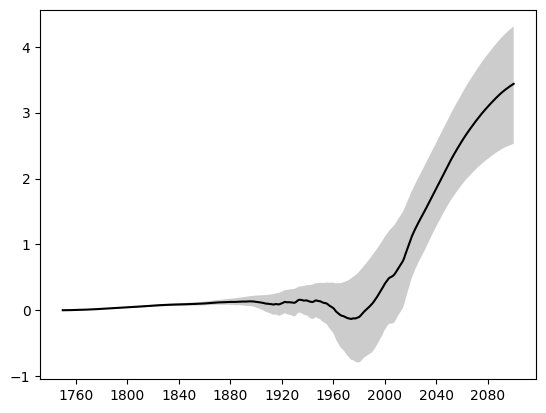

In [43]:
plot_range(df, 'Surface Air Temperature Change', plt.gca())

In [44]:
dates=['1950-01-01','1970-01-01','1990-01-01','2005-01-01','2018-01-01']
targ=pd.concat([df.groupby(['run_id', 'variable'])[d].sum().unstack() for d in dates],axis=1)   
targ.columns=pd.MultiIndex.from_product([dates,output_vars])
nflds=targ.shape[1]


In [45]:
def merge_dicts(dc):
    """Given two dictionaries, merge them into a new dict as a shallow copy."""
    x=dc['pamset_udm']
    y=dc['pamset_emiconc']
    z = x.copy()
    z.update(y)
    return z

In [46]:
pdict=distrorun1.cfgs
mdict=[ merge_dicts(d) for d in pdict ]
pmat=pd.DataFrame(mdict)

In [50]:
parammat=pmat.loc[:, (pmat != pmat.iloc[0]).any()] 
parammat

,W,lambda,qdirso2,qindso2,qbc,qoc,beta_f
0,1.772444,1.043589,-0.842974,-2.271347,0.374655,-0.187328,0.151691
1,0.737136,1.132485,-0.714970,-1.926447,0.317764,-0.158882,0.382163
2,0.587812,0.569587,-0.318470,-0.858099,0.141542,-0.070771,0.240482
3,1.035978,1.117735,-0.806205,-2.172275,0.358313,-0.179157,0.339150
4,0.835619,0.919575,-0.226250,-0.609617,0.100555,-0.050278,0.361859
...,...,...,...,...,...,...,...
9995,1.710771,0.683533,-0.703247,-1.894859,0.312554,-0.156277,0.349105
9996,0.671114,1.196523,-0.650231,-1.752012,0.288992,-0.144496,0.221272
9997,0.993900,0.741401,-0.811671,-2.187003,0.360743,-0.180371,0.165927
9998,0.863612,1.035568,-0.365625,-0.985156,0.162500,-0.081250,0.270726


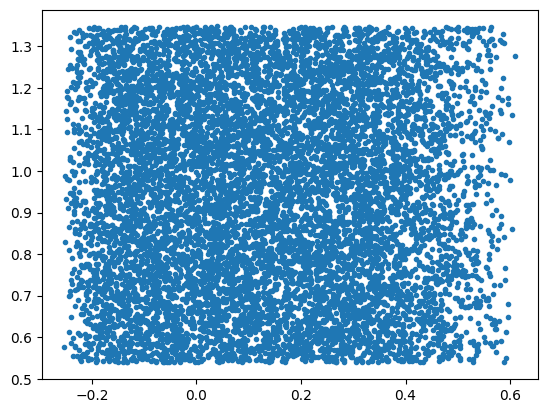

In [52]:
plt.plot(targ['1950-01-01']['Surface Air Temperature Change'],pmat['lambda'],'.')

In [31]:
from sklearn.model_selection import train_test_split
XTraining, XValidation, YTraining, YValidation = train_test_split(parammat,targ,test_size=0.1, shuffle=False) # before model building


In [70]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern

In [85]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

In [86]:
reg = LinearRegression().fit(XTraining, YTraining)

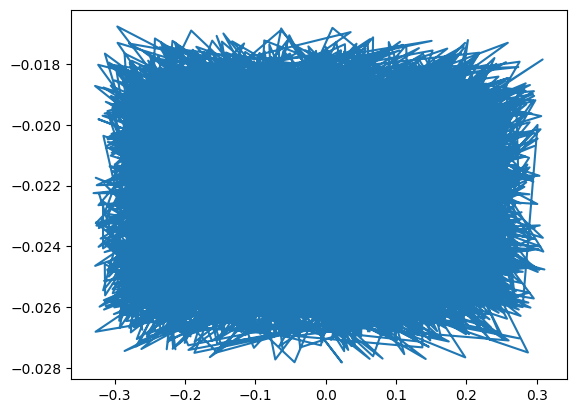

In [94]:
plt.plot(YTraining.iloc[:,0],reg.predict(XTraining)[:,0])

In [35]:
sgd_regressor = SGDRegressor( 
    max_iter=10000, alpha=0.0001, learning_rate='invscaling', random_state=42) 

In [36]:
est = make_pipeline(StandardScaler(), SGDRegressor())
est.fit(XTraining, YTraining.iloc[:,1])
est.predict(XTraining)

array([0.13836148, 0.14352665, 0.14317986, ..., 0.13504974, 0.1352027 ,
       0.12775698])

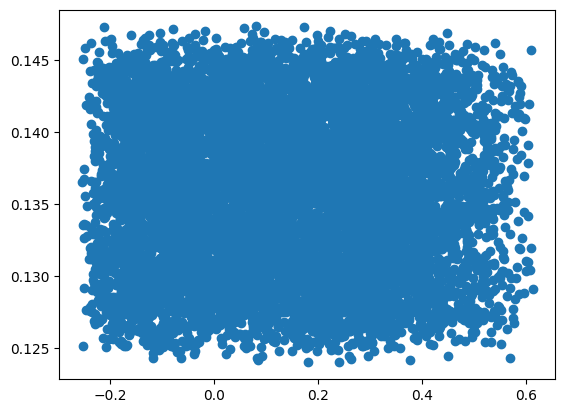

In [37]:
plt.plot(YTraining.iloc[:,1], est.predict(XTraining), 'o')

In [38]:
XTraining.shape

(9000, 7)

In [39]:
YTraining

1950-01-01                                 1970-01-01  \
       Heat Uptake Surface Air Temperature Change Heat Uptake   
run_id                                                          
0         0.176040                       0.385700    0.217830   
1         0.162963                       0.325891    0.260342   
10       -0.305898                      -0.228303   -0.985006   
100       0.035952                       0.192910   -0.088345   
1000     -0.272149                      -0.183410   -0.910216   
...            ...                            ...         ...   
9094     -0.210798                      -0.122536   -0.633453   
9095      0.128750                       0.296461    0.156863   
9096     -0.207874                      -0.092715   -0.773760   
9097     -0.220603                      -0.133581   -0.671039   
9098     -0.129553                      -0.004305   -0.529641   

                                       1990-01-01  \
       Surface Air Temperature Change Heat Uptake   
run_id                                              
0                            0.413352    0.684665   
1                            0.390955    0.612204   
10                          -0.880623   -0.215204   
100                          0.059162    0.423871   
1000                        -0.798497   -0.155972   
...                               ...         ...   
9094                        -0.536459    0.001680   
9095                         0.300981    0.571134   
9096                        -0.636003   -0.040458   
9097                        -0.573932   -0.016662   
9098                        -0.393639    0.129926   

                                       2005-01-01  \
       Surface Air Temperature Change Heat Uptake   
run_id                                              
0                            0.785380    0.831496   
1                            0.711026    0.689802   
10                          -0.931084    0.161924   
100                          0.309398    0.582386   
1000                        -0.819716    0.216605   
...                               ...         ...   
9094                        -0.468604    0.169341   
9095                         0.611090    0.678438   
9096                        -0.605997    0.332342   
9097                        -0.514148    0.172868   
9098                        -0.275202    0.397053   

                                       2018-01-01  \
       Surface Air Temperature Change Heat Uptake   
run_id                                              
0                            1.159451    1.197056   
1                            0.981829    0.937326   
10                          -0.462118    1.242793   
100                          0.661743    1.098593   
1000                        -0.345481    1.259392   
...                               ...         ...   
9094                        -0.132662    0.999785   
9095                         0.918558    1.019425   
9096                        -0.120649    1.311483   
9097                        -0.160687    1.031861   
9098                         0.148967    1.207340   

                                       
       Surface Air Temperature Change  
run_id                                 
0                            1.535210  
1                            1.249784  
10                           0.112296  
100                          1.038497  
1000                         0.229108  
...                               ...  
9094                         0.268653  
9095                         1.231310  
9096                         0.457166  
9097                         0.261143  
9098                         0.635628  

[9000 rows x 10 columns]

In [40]:
XTraining

,W,lambda,qdirso2,qindso2,qbc,qoc,beta_f
0,1.408930,0.847738,-0.220844,-0.595052,0.098153,-0.049076,0.117737
1,0.772147,0.554754,-0.155152,-0.418050,0.068957,-0.034478,0.346669
2,0.737528,0.916283,-0.460409,-1.240545,0.204626,-0.102313,0.403956
3,1.630390,0.650255,-0.613700,-1.653582,0.272756,-0.136378,0.172650
4,0.770383,0.563638,-0.737022,-1.985865,0.327565,-0.163783,0.153687
...,...,...,...,...,...,...,...
8995,1.471841,1.193405,-0.661415,-1.782145,0.293962,-0.146981,0.381752
8996,2.276360,1.174302,-0.271365,-0.731178,0.120607,-0.060303,0.129406
8997,1.500092,0.770592,-0.736615,-1.984769,0.327385,-0.163692,0.127109
8998,1.385624,0.579812,-0.740428,-1.995043,0.329079,-0.164540,0.357250


In [41]:


sgd_regressor.fit(XTraining, YTraining.iloc[:,1]) 
y_pred = sgd_regressor.predict(XTraining) 

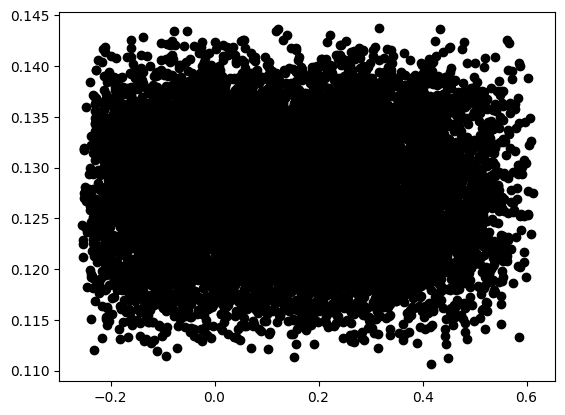

In [42]:
plt.plot(YTraining.iloc[:,1], y_pred, 'o', color='black')

In [43]:
X=parammat
y=targ


In [44]:
y.iloc[:,0]

run_id
0       0.176040
1       0.162963
10     -0.305898
100     0.035952
1000   -0.272149
          ...   
9995   -0.091272
9996   -0.122213
9997   -0.134682
9998   -0.255718
9999   -0.028600
Name: (1950-01-01, Heat Uptake), Length: 10000, dtype: float64

In [46]:


kernel = RBF(np.ones(parammat.shape[1])) * Matern(length_scale=np.ones(parammat.shape[1]))
gp = GaussianProcessRegressor(kernel=kernel)

gp.fit(XTraining.iloc[:,:1000], YTraining.iloc[:,:1000])

NameError: name 'RBF' is not defined

In [1]:
plt.plot(gp.predict(XTraining), YTraining, 'k.')
plt.plot(gp.predict(XValidation), YValidation, 'r.')

NameError: name 'plt' is not defined

In [47]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
print(tf.config.list_physical_devices())

2024-05-08 19:27:43.757471: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-08 19:27:43.813294: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-08 19:27:43.814560: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-08 19:27:53.714614: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.13.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [77]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(5, activation='tanh'),
      layers.Dense(nflds)
  ])

  model.compile(loss='mae',
                optimizer=tf.keras.optimizers.AdamW(0.001))
  return model

In [78]:
normalizer = tf.keras.layers.Normalization(input_shape=[parammat.shape[1],], axis=-1)

In [79]:
normalizer.adapt(parammat)

In [80]:
dnn_model = build_and_compile_model(normalizer)


In [81]:
X_train = tf.convert_to_tensor(XTraining, dtype=tf.float32)
Y_train = tf.convert_to_tensor(YTraining, dtype=tf.float32)
X_dev = tf.convert_to_tensor(XValidation, dtype=tf.float32)
Y_dev = tf.convert_to_tensor(YValidation, dtype=tf.float32)

In [82]:
from tqdm.keras import TqdmCallback

In [83]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 1


In [84]:
history=dnn_model.fit(X_train, Y_train, epochs=10000, batch_size=1000, validation_data=(X_dev, Y_dev),verbose=0,callbacks=[TqdmCallback(verbose=0)])


0epoch [00:00, ?epoch/s]

KeyboardInterrupt: 

In [64]:
pred = dnn_model.predict(X_dev)
pred_t = dnn_model.predict(X_train)

282/282 [==============================] - 0s 501us/step


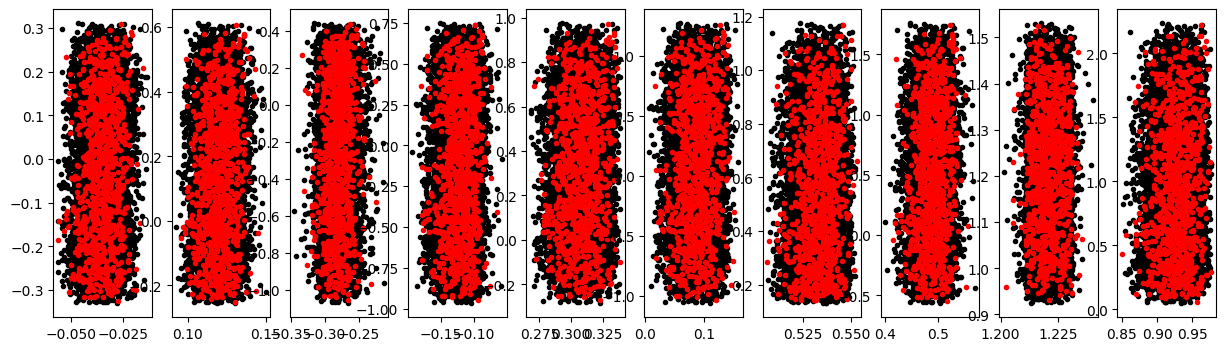

In [66]:
fig, ax = plt.subplots(1, nflds, figsize=(15, 4))


for i in np.arange(nflds):
  ax[i].plot(pred_t[:,i],Y_train[:,i],'k.')
  ax[i].plot(pred[:,i],Y_dev[:,i],'r.')

